### Authors : Rania BEN KMICHA , Désiré OUEDRAOGO 

In [1]:
# Contrôle de version
import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

# Packages nécessaires
import numpy as np
import os
import re
import matplotlib.pyplot as plt
# A la première utilisation de nltk, télécharger les données nécessaires
import nltk
#nltk.download('punkt')

## Dense Representations 

### Word Embeddings : Distributed representations via the distributional hypothesis 

**Goal**: We will try to obtain dense representations (as vectors of real numbers) of words (and possibly sentences). These representations are intended to be distributed: they are non-local representations. We represent an object as a combination of *features*, as opposed to the attribution of a dedicated symbol: see the founding work of Geoffrey Hinton, among others, on the subject: [Distributed Representations](https://web.stanford.edu/~jlmcc/papers/PDP/Chapter3.pdf).

The term *distributed* representations is very general, but is what we are looking for. The challenge is therefore to be able to build, automatically, such representations.

**Underlying idea**: It is based on the distributional hypothesis: contextual information is sufficient to obtain a viable representation of linguistic objects.
 - For a large class of cases [...] the meaning of a word is its use in the language." Wittgenstein (Philosophical Investigations, 43 - 1953)
 - You shall know a word by the company it keeps, Firth.

Thus, a word can be characterized by the words that accompany it, via co-occurrence counts. Two words with a similar meaning will have a similar contextual distribution and are therefore more likely to appear in similar contexts. This hypothesis can be used as a justification for the application of statistics to semantics (information extraction, semantic analysis). It also allows some form of generalization: we can assume that the information we have about a word will be generalized to words with a similar distribution. 

**Motivation**: The goal is to obtain distributed representations in order to be able to effectively**:
- Directly perform a semantic surface analysis.
- Use it as a source of information for other language-related models and applications, especially for sentiment analysis. 


**Terminology**: Be careful not to confuse the idea of *distributed* and *distributional* representation. The latter generally indicates (for words) that the representation has been obtained strictly from co-occurrence counts, whereas additional information (document labels, part of speech tags, ...) can be used to build distributed representations. 
The models that allow to build these dense representations, in the form of vectors, are often called *vector spaces models*. These representations are also regularly called *word embeddings*, because the words are embedded in a vector space. In French, we often find the term *word embedding* or *lexical embedding*.

### Getting representations: counts of occurrences and co-occurrences

Depending on the type of corpus available, different types of distributional information can be obtained. If we have access to a collection of documents, we can thus choose to count the number of occurrences of each word in each document, to obtain a $words \times documents$ matrix: it is on this principle that **Tf-Idf** is built. We will now look at a more general case: we have a large amount of data in text form, and we want to obtain representations of words in the form of vectors of reduced size, without the need to divide them into documents or categories. 

Suppose we have a corpus containing $T$ different words. We will construct a $\mathbf{M}$ matrix of size $T \times T$ which will contain the number of co-occurrences between words. There will be different factors to consider when constructing this matrix: 

- How do you define the 'context' of a word - context which will tell you what terms co-occur with that word?

We can choose to use different scales: the document, the sentence, the nominal group, or simply a window of $k$ words, depending on the information we want to capture.


- How do we quantify the importance of the counts? 

$\rightarrow$ For example, we can give a decreasing weight to a co-occurrence according to the distance between the two words concerned ($\frac{1}{d+1}$ for a separation by $d$ words).


- Should we keep all the words that appear in the corpus? 

$\rightarrow$ Usually not. We will see that for large corpora, the number $T$ of different words is huge. Second, even if the number of words is reasonable, we will have very little distributional information on the rarest words, and the representation obtained will be of poor quality. We will have to ask ourselves how to filter these words, and how to treat the words we choose not to represent.  

#### Example:

Let's look at the following text:

*I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue.*

We choose to define the context of a word as the sentence to which it belongs, and to not use any weighting.
We obtain the following matrix: 

|     *         | I | the | down | walked | boulevard | avenue | walk | ran | city |
|---------------|---|-----|------|--------|-----------|--------|------|-----|------|
| I             | 0 |      6 |    6 |   2 |         2 |      2 |   2 |    1 |    1 |
| the           | 6 |      2 |    7 |   2 |         2 |      3 |   3 |    1 |    1 |
| down          | 6 |      7 |    2 |   3 |         3 |      2 |   2 |    1 |    1 |
| walked        | 2 |      2 |    3 |   0 |         1 |      1 |   0 |    0 |    0 |
| boulevard     | 2 |      2 |    3 |   1 |         0 |      0 |   0 |    1 |    0 |
| avenue        | 2 |      3 |    2 |   1 |         0 |      0 |   1 |    0 |    0 |
| ran           | 2 |      3 |    2 |   0 |         0 |      1 |   0 |    0 |    1 |
| walk          | 1 |      1 |    1 |   0 |         1 |      0 |   0 |    0 |    0 |
| city          | 1 |      1 |    1 |   0 |         0 |      0 |   1 |    0 |    1 |

In [2]:
def clean_and_tokenize(text):
    """
    Cleaning a document with:
        - Lowercase        
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """        
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)
    
    tokens = text.split()        
    return tokens

### In practice: get a Vocabulary.

To begin, we will implement separately a function returning the vocabulary. Here we will have to be able to control its size, by indicating a maximum number of words. We add, at the end, an "unknown" word that will replace all the words that do not appear in our "limited" vocabulary. 

**Remarks:**
- Use tokenization to obtain words from a document !
- Add a special token ```<UNK>``` to deal with out-of-vocabulary words: even if you don't put a limit, you might encounter new words when working with new data. 
- You need to count words and sort them by frequency in order to only keep the most frequent ones. It is not necessary to count 'unknown' words. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [42]:
def vocabulary(corpus, count_threshold=5, voc_threshold=0):
    """    
    Function using word counts to build a vocabulary
    Params:
        corpus (list of list of strings): corpus of sentences
        count_threshold (int): number of occurences necessary for a word to be included in the vocabulary
        voc_threshold (int): maximum size of the vocabulary - 0 (default) indicates there is no max
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency 
        vocabulary_word_counts (dictionary): keys: list of distinct words across the corpus
                                             values: word counts in the corpus
    """
    n_samples = len(corpus)
    word_counts = {}
    words = []
    for text in corpus:
        words += list(clean_and_tokenize(text)) # list of all words
    for word in words:
        if word not in word_counts.keys():
            word_counts[word] = 1
        else:
            word_counts[word] += 1
    #sorted()
    word_counts = {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1], reverse=True)} 
    filtered_word_counts={}
    for k,v in word_counts.items():
        if voc_threshold > 0 :
            if v>=count_threshold and len(filtered_word_counts.keys()) < voc_threshold:
                filtered_word_counts[k] = v
        else :
            if v>=count_threshold:
                filtered_word_counts[k] = v
       
    vocabulary = {}
    vocabulary_word_counts = filtered_word_counts
    vocabulary_word_counts['UNK']=0
    voc = list(vocabulary_word_counts.keys())
    vocabulary = dict(zip(voc, range(len(voc))))  
    
    return vocabulary, vocabulary_word_counts

In [4]:
# Example for testing:

corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']

voc, counts = vocabulary(corpus, count_threshold = 3)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
#  {'down': 6, 'the': 6, 'i': 5, 'UNK': 0}

voc, counts = vocabulary(corpus, count_threshold = 0)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
#  {'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}

{'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
{'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}
{'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
{'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}


### 3.B Obtaining co-occurences:

The function takes as input the corpus (a list of strings, corresponding to documents/sentences) and a vocabulary, as well as the size of the context window. We can also implement the simplest solution: the context of a word being the full document to which it belongs. 
Finally, we can implement the possibility of making linearly decrease the importance of the context of a word when getting further from the input word.

**Remark:**
- The matrix we are building is symmetric: we can only build half of it !
<div class='alert alert-block alert-info'>
            Code:</div>

In [5]:
def co_occurence_matrix(corpus, vocabulary, window=0, distance_weighting=False):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
        distance_weighting (bool): indicates if we use a weight depending on the distance between words for co-oc counts
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input    
    """ 
    l = len(vocabulary)
    M = np.zeros((l,l))
    for sent in corpus:
        # Obtenir la phrase:
        sent = clean_and_tokenize(sent)
        # Obtenir les indexs de la phrase grace au vocabulaire: 
        sent_idx = []
        for word in sent:
            if vocabulary.get(word) != None : 
                sent_idx.append(vocabulary.get(word))
            else:
                sent_idx.append(vocabulary.get('UNK'))
        # Parcourir les indexs de la phrase et ajouter 1 / dist(i,j) à M[i,j] si les mots d'index i et j apparaissent dans la même fenêtre. 
        for i, idx_i in enumerate(sent_idx):
            # On vérifie que le mot est reconnu par le vocabulaire:
            if idx_i > -1:
                # Si on considère un contexte limité:
                if window > 0:
                    # On crée une liste qui contient les indexs de la fenêtre à gauche de l'index courant 'idx_i'
                    l_ctx_idx = [sent_idx[j] for j in range(max(0,i - window),i)]
                    # A compléter
                    
                # Si on considère que le contexte est la phrase entière:
                else:
                    # La liste qui contient le contexte à gauche du mot est plus facile à créer:
                    l_ctx_idx = sent_idx[:i]
                    # A compléter
                # On parcourt cette liste et on update M[i,j]:    
                for j, idx_j in enumerate(l_ctx_idx):
                    # ... en s'assurant que le mot correspondant à 'idx_j' est reconnu par le vocabulaire
                    if idx_j > -1:
                        # Calcul du poids:
                        if distance_weighting:
                            weight = 1.0 
                            # A compléter *
                            if i-j != 0:
                               weight = 1/abs(i-j)
                        else:
                            weight = 1.0
                        M[idx_i, idx_j] += weight * 1.0
                        M[idx_j, idx_i] += weight * 1.0
    return M  

In [6]:
print(co_occurence_matrix(corpus, voc, 0, False))

[[2. 7. 6. 3. 3. 2. 2. 1. 1. 0.]
 [7. 2. 6. 2. 2. 3. 3. 1. 1. 0.]
 [6. 6. 0. 2. 2. 2. 2. 1. 1. 0.]
 [3. 2. 2. 0. 1. 1. 0. 0. 0. 0.]
 [3. 2. 2. 1. 0. 0. 0. 1. 0. 0.]
 [2. 3. 2. 1. 0. 0. 1. 0. 0. 0.]
 [2. 3. 2. 0. 0. 1. 0. 0. 1. 0.]
 [1. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### 3.C Application to a real data set

We're going to work with the **imdb** data.

In [7]:
from glob import glob
filenames_neg = sorted(glob(os.path.join('.', 'aclImdb', 'train', 'neg', '*.txt')))
filenames_pos = sorted(glob(os.path.join('.', 'aclImdb', 'test', 'pos', '*.txt')))

texts_neg = [open(f, encoding="utf8").read() for f in filenames_neg]
texts_pos = [open(f, encoding="utf8").read() for f in filenames_pos]
texts = texts_neg + texts_pos

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
y = np.ones(len(texts), dtype=np.int)
y[:len(texts_neg)] = 0.

print("%d documents" % len(texts))

25000 documents


C:\Users\ouedr\AppData\Local\Temp\ipykernel_20320\3405308050.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.ones(len(texts), dtype=np.int)


#### Quick study of the data

We would like to get an idea of what's in these film reviews before we proceed. So we'll get the vocabulary (in full) and represent the frequencies of the words, in order (be careful, you'll have to use a logarithmic scale): we should find back Zipf's law. This will give us an idea of the size of the vocabulary we will be able to choose: it's a matter of making a compromise between the necessary resources (size of the objects in memory) and the amount of information we can get from them (rare words can bring a lot of information, but it's difficult to learn good representations of them, because they are rare!). 

<div class='alert alert-block alert-info'>
            Code:</div>

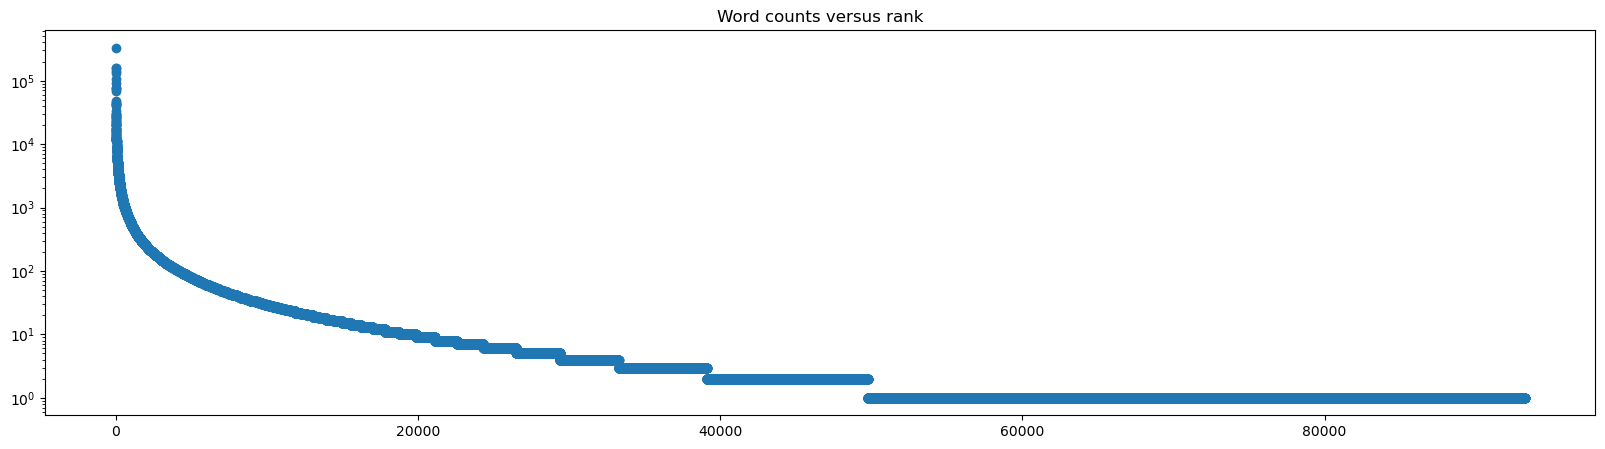

Vocabulary size: 93231
Part of the corpus by taking the "x" most frequent words ?
x =  500
 69.124630 %


In [8]:
# We would like to display the curve of word frequencies given their rank (index) in the vocabulary
vocab, word_counts = vocabulary(texts)
#
# 
#

# We can for example use the function plt.scatter()
plt.figure(figsize=(20,5))
plt.title('Word counts versus rank')
plt.scatter(vocab.values(), word_counts.values())
# 
#
plt.yscale('log')
plt.show()

# We would like to know how much of the data is represented by the 'k' most frequent words
print('Vocabulary size: %i' % len(vocab))
print('Part of the corpus by taking the "x" most frequent words ?')
#
while 1:
    x=int(input())
    if x < len(vocab):
        break

lst_of_fword_occ = list(word_counts.values())[:x]
sum_of_occ = sum(lst_of_fword_occ)
result = sum_of_occ/sum(list(word_counts.values()))
print("x = ",x)
print(" {0:1f} %".format(result*100))


**Result of the analysis**: we can be satisfied with a vocabulary of 10,000 or even 5,000 words - this is important, because it will determine the size of the objects we will manipulate.

#### Obtaining the matrices:
We can now get the co-occurence matrices with parameters of our choosing !

In [9]:
vocab_5k, word_counts_5k = vocabulary(texts, 0, 5000)
M5dist = co_occurence_matrix(texts, vocab_5k, window=5, distance_weighting=True)
M20 = co_occurence_matrix(texts, vocab_5k, window=20, distance_weighting=False)
print(M5dist.shape)
print(M20.shape)

(5001, 5001)
(5001, 5001)


In [10]:
print(M5dist[-1])

[7.34404393e+03 3.80292974e+03 4.26779039e+03 ... 3.01301407e+00
 1.58905923e+00 1.77953231e+04]


In [11]:
print(vocab_5k['cinema'])
print(M5dist[429])
print(M20[429])

440
[ 9.36018576  9.09404357  8.17571046 ...  0.          0.
 12.15935411]
[2.621e+03 1.640e+03 1.513e+03 ... 2.000e+00 0.000e+00 3.763e+03]


### Vector comparison 

We can use these very large-dimensional vectors for a very simple semantic analysis: for example, by looking for the nearest neighbors of a words. However, we need to be careful to the distance that we use (euclidean, cosine). Vector normalization can also play a role; in any way, we need to not over-interpret this type of results. 

In [12]:
def euclidean(u, v):
    return np.linalg.norm(u-v)

def length_norm(u):
    return u / np.sqrt(u.dot(u))

def cosine(u, v):
    return 1.0 - length_norm(u).dot(length_norm(v))

from sklearn.neighbors import NearestNeighbors

def print_neighbors(distance, voc, co_oc, mot, k=10):
    inv_voc = {id: w for w, id in voc.items()}
    neigh = NearestNeighbors(n_neighbors=k, algorithm='brute', metric=distance)
    neigh.fit(co_oc) 
    dist, ind = neigh.kneighbors([co_oc[voc[mot]]])
    print("Plus proches voisins de %s selon la distance '%s': " % (mot, distance.__name__))
    print([[inv_voc[i] for i in s[1:]] for s in ind])
    
print("Avec un contexte large, sans prendre en compte la distance entre les mots:")    
print_neighbors(euclidean, vocab_5k, M20, 'good')
print_neighbors(cosine, vocab_5k, M20, 'good')
print("")
print("Avec un contexte plus petit, et en réduisant l'impact des paires de mots selon leur distance:")    
print_neighbors(euclidean, vocab_5k, M5dist, 'good')
print_neighbors(cosine, vocab_5k, M5dist, 'good') 

Avec un contexte large, sans prendre en compte la distance entre les mots:
Plus proches voisins de good selon la distance 'euclidean': 
[['very', 'what', 'more', 'even', 'no', 'time', 'there', 'story', 'only']]
Plus proches voisins de good selon la distance 'cosine': 
[['very', 'great', 'decent', 'pretty', 'not', 'funny', 'cool', 'really', 'just']]

Avec un contexte plus petit, et en réduisant l'impact des paires de mots selon leur distance:
Plus proches voisins de good selon la distance 'euclidean': 
[['great', 'very', 'bad', 'what', 'story', 'time', 'well', 'made', 'its']]
Plus proches voisins de good selon la distance 'cosine': 
[['great', 'very', 'simple', 'fun', 'decent', 'little', 'strange', 'funny', 'perfect']]


#### Vector re-weighting:

Similarly as before, we may want to alter the representations to obtain better features - depending on what use we will have for them.

**Normalization**: Very easy: we want to cancel the influence of the magnitude of the counts on the representation.

$$\mathbf{m_{normalized}} = \left[ 
   \frac{m_{1}}{\sum_{i=1}^{n}m_{i}}, 
   \frac{m_{2}}{\sum_{i=1}^{n}m_{i}}, 
   \ldots
   \frac{m_{n}}{\sum_{i=1}^{n}m_{i}}, 
\right]$$
 
**Pointwise Mutual Information**: The aim is to assess the extent to which the co-occurrence of the two terms is *unexpected*. This measure is the ratio of the joint probability of the two words and the product of their individual probabilities:
$$
\text{PMI}(x,y) = \log \left( \frac{P(x,y)}{P(x)P(y)} \right)
$$
The joint probability of the two words corresponds to the number of times they are observed together, divided by the total number of co-occurrences in the corpus: 
$$ P(\mathbf{M},w_{1},w_{2}) = \frac{M_{w_{1},w_{2}}}{\sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j}} $$
The individual probability of a word simply corresponds to its frequency, which can be calculated by counting all co-occurrences where that word appears:
$$ P(\mathbf{M},w) = \frac{\sum_{j=1}^{m} M_{w,j}}{\sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j}} $$
Hence,
$$ 
\text{PMI}(\mathbf{M},w_{1},w_{2}) = \log  \frac{M_{w_{1},w_{2}} \times \left( \sum_{i=1}^{n}\sum_{j=1}^{n} M_{i,j} \right)}{\left( \sum_{j=1}^{n} M_{w_{1},j} \right) \times \left( \sum_{i=1}^{n}M_{i,w_{2}} \right)} 
$$
We thus calculate the discrepancy between the observation we have made in our corpus and the frequency of appearance of these terms if we consider them independent - i.e. we assume that their co-occurrence is a coincidence.

The main problem with this measure is that it is not adapted to the case where no co-occurrence is observed. Since the PMI is supposed to return a positive quantity if more co-occurrences are observed than expected, and a negative quantity if fewer co-occurrences are observed, we cannot choose to replace $\log(0)$ by $0$. A commonly used solution is to use the **Positive PMI**, which sets all negative values to $0$.
 
 $$ \text{PPMI}(\mathbf{M},w_{1},w_{2}) = 
 \begin{cases}
 \text{PMI}(\mathbf{M},w_{1},w_{2}) & \textrm{if } \text{PMI}(\mathbf{M},w_{1},w_{2}) > 0 \\
 0 & \textrm{otherwise}
 \end{cases} $$

In [13]:
def pmi(co_oc, positive=True):
    sum_vec = co_oc.sum(axis=0)
    sum_tot = sum_vec.sum()
    with np.errstate(divide='ignore'):
        pmi = np.log((co_oc * sum_tot) / (np.outer(sum_vec, sum_vec)))                 
    pmi[np.isinf(pmi)] = 0.0  # log(0) = 0
    if positive:
        pmi[pmi < 0] = 0.0
    return pmi

In [14]:
PPMI5 = pmi(M5dist)
PPMI20 = pmi(M20)

print("Avec la PPMI:")    
print_neighbors(euclidean, vocab_5k, PPMI5, 'good')
print_neighbors(cosine, vocab_5k, PPMI5, 'good')
print_neighbors(euclidean, vocab_5k, PPMI20, 'good')
print_neighbors(cosine, vocab_5k, PPMI20, 'good')

Avec la PPMI:
Plus proches voisins de good selon la distance 'euclidean': 
[['movie', 'this', 'it', 'the', 'is', 'was', 'but', 'film', 'one']]
Plus proches voisins de good selon la distance 'cosine': 
[['great', 'decent', 'but', 'and', 'acting', 'some', 'bad', 'were', 'overall']]
Plus proches voisins de good selon la distance 'euclidean': 
[['but', 'is', 'movie', 'and', 'it', 'this', 'the', 'not', 'that']]
Plus proches voisins de good selon la distance 'cosine': 
[['great', 'bad', 'pretty', 'acting', 'decent', 'but', 'movie', 'very', 'overall']]


### Word representations through count-based methods: reducing the dimension of co-occurence matrices

#### Motivation

The goal is not only to reduce the size of the data representation (then, we will work with smaller pre-determined sized representations, instead of working with vectors of the size of the vocabulary) but also showcase higher-level relationships between words: by reducing their representations to the *most important dimensions* of the data, we end up *generalizing* some properties of words.

#### Dimension reduction via SVD 

A matrix is a linear transformation: applying a SVD to it is decomposing our linear transformation in a product of linear transformations of different types. We are changing the basis and replacing our data in a different space, using **eigenvectors**:

$$ \mathbf{M} = \mathbf{U} \mathbf{\lambda} \mathbf{V}^{\text{T}} $$

Matrices $\mathbf{U}$, $\mathbf{\lambda}$, and $\mathbf{V}$ have the following properties:
- $\mathbf{U}$ and $\mathbf{V}$ are orthogonal matrices ($\mathbf{U}^{\text{T}} = \mathbf{U}^{-1}$ and $\mathbf{V}^{\text{T}} = \mathbf{V}^{-1}$). They contain the eingenvectors to the left and to the right of $\mathbf{M}$.
- $\mathbf{\lambda}$ is a diagonal matrix: careful, it is not necessarily square. diagonal coefficient are the eigenvalues of $\mathbf{M}$.

Then, the *most important dimensions* correspond to the highest eigenvalues. Reducing our data to a dimension $k$ corresponds to only keeping vectors corresponding to the $k$ first eigenvalues - which in turns is equivalent to keeping only the first $k$ vectors of $U$. 
We use ```TruncatedSVD``` from ```scikit-learn```:

In [15]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300)
SVDEmbeddings = svd.fit_transform(M5dist)
print(SVDEmbeddings.shape)
SVDEmbeddings[vocab_5k['UNK']]

print_neighbors(euclidean, vocab_5k, SVDEmbeddings, 'good')
print_neighbors(cosine, vocab_5k, SVDEmbeddings, 'good')

(5001, 300)
Plus proches voisins de good selon la distance 'euclidean': 
[['great', 'very', 'bad', 'what', 'story', 'time', 'well', 'made', 'its']]
Plus proches voisins de good selon la distance 'cosine': 
[['great', 'very', 'simple', 'decent', 'perfect', 'terrific', 'fun', 'strange', 'little']]


Note: When applying this method to the count matrix $\mathbf{M}$ of dimension $T \times D$, where $\mathbf{M}_{t,d}$ contains the number of occuerences of the word $t$ in the document $d$, we obtain the method called **Latent Semantic Analysis**, which is used to detect latent (semantic) components allowing to group documents together.

#### Visualization in two dimensions

We will now use **principal components analysis** (PCA) to visualize our data in two dimensions. This is equivalent to applying SVD to the covariance matrix of the data, in order for the principal components to be independant from each other an maximize the variance of the data. We use the class ```PCA``` from ```scikit-learn```: 

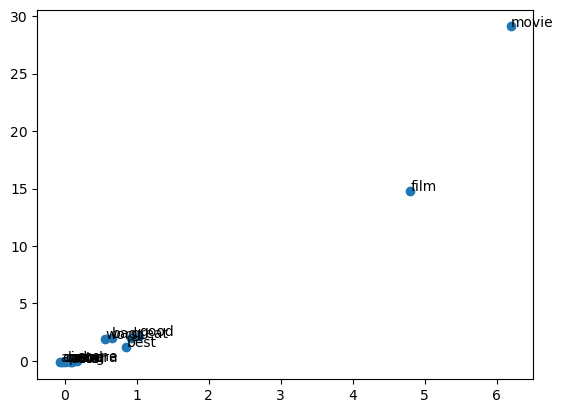

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
Emb = pca.fit_transform(M5dist)

words = ['bad', 'good', 'best', 'worst', 'poor', 'great',
         'dialog', 'role', 'actor', 'camera', 'scene',
         'film', 'movie', 'award']
ind_words = [vocab_5k[w] for w in words]

x_words = [Emb[ind,0] for ind in ind_words]
y_words = [Emb[ind,1] for ind in ind_words]

fig, ax = plt.subplots()
ax.scatter(x_words, y_words)

for i, w in enumerate(words):
    ax.annotate(w, (x_words[i], y_words[i]), (x_words[i] + 0.001, y_words[i] + 0.001))

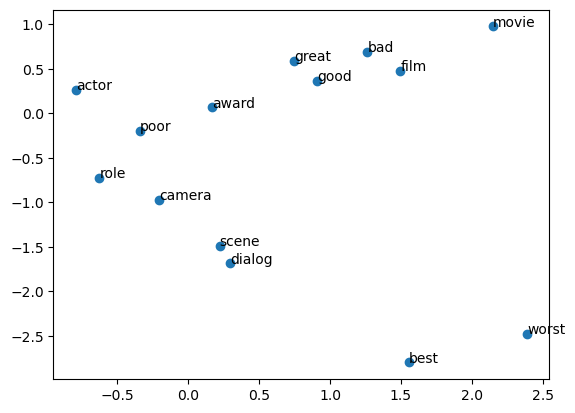

In [17]:
Norm5 = M5dist / np.linalg.norm(M5dist, ord=2, axis=1, keepdims=True)

pca = PCA(n_components=2, whiten=True)
Emb = pca.fit_transform(Norm5)

words = ['bad', 'good', 'best', 'worst', 'poor', 'great',
         'dialog', 'role', 'actor', 'camera', 'scene',
         'film', 'movie', 'award']
ind_words = [vocab_5k[w] for w in words]
x_words = [Emb[ind,0] for ind in ind_words]
y_words = [Emb[ind,1] for ind in ind_words]

fig, ax = plt.subplots()
ax.scatter(x_words, y_words)

for i, w in enumerate(words):
    ax.annotate(w, (x_words[i], y_words[i]), (x_words[i] + 0.001, y_words[i] + 0.001))

## Word representations through prediction-based methods: commonly used algorithms

The idea here is to define a set of representations ${w_{i}}_{i=1}^{V}$, of predefined dimension $d$ (here, we will work with $d = 300$), for all the words $i$ of the vocabulary $V$ - then **train** these representations to match what we want. 

#### Glove

The objective defined by Glove ([Pennington et al. (2014)](http://www.aclweb.org/anthology/D/D14/D14-1162.pdf)) is to learn from the vectors $w_{i}$ and $w_{k}$ so that their scalar product corresponds to the logarithm of their **Pointwise Mutual Information**: 


$$ w_{i}^\top w_{k} = (PMI(w_{i}, w_{k}))$$


In the article, this objective is carefully justified by a reasoning about the operations one wants to perform with these vectors and the properties they should have - in particular, symmetry between rows and columns (see the article for more details).  
The final goal obtained is the following, where $M$ is the co-occurrence matrix:


$$\sum_{i, j=1}^{|V|} f\left(M_{ij}\right)
  \left(w_i^\top w_j + b_i + b_j - \log M_{ij}\right)^2$$
  
 
Here, $f$ is a *scaling* function that reduces the importance of the most frequent co-occurrence counts: 


$$f(x) 
\begin{cases}
(x/x_{\max})^{\alpha} & \textrm{if } x < x_{\max} \\
1 & \textrm{otherwise}
\end{cases}$$


Usually, we choose $\alpha=0.75$ and $x_{\max} = 100$, although these parameters may need to be changed depending on the data.

The following code uses the gensim API to retrieve pre-trained representations (It is normal that the loading is long).

In [18]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")

c:\Users\ouedr\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


We can extract the embedding matrix this way, and check its size:

In [19]:
loaded_glove_embeddings = loaded_glove_model.vectors
print(loaded_glove_embeddings.shape)

(400000, 300)


We can see that there are $400,000$ words represented, and that the embeddings are of size $300$. We define a function that returns, from the loaded model, the vocabulary and the embedding matrix according to the structures we used before. We add, here again, an unknown word "UNK" in case there are words in our data that are not part of the $400,000$ words represented here. 

In [20]:
def get_glove_voc_and_embeddings(glove_model):
    voc = {word : index for word, index in enumerate(glove_model.index_to_key)}
    voc['UNK'] = len(voc)
    embeddings = glove_model.vectors
    return voc, embeddings

In [21]:
loaded_glove_voc, loaded_glove_embeddings = get_glove_voc_and_embeddings(loaded_glove_model)

In order to compare the representations loaded here and the ones produced with word2vec, the same vocabulary should be used. For this purpose, I reuse the following code to create a $5000$ word vocabulary from the data, and I add at the end a function that returns the matrix of representations loaded with Glove for these $5000$ words only, in the right order. 

In [22]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.key_to_index.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc),glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

In [23]:
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, vocab_5k)

This function takes as input the model loaded using the Gensim API, as well as a vocabulary we created ourselves, and returns the embedding matrix from the loaded model, for the words in our vocabulary and in the right order.
Note: unknown words are represented by a vector of zeros:

In [24]:
print(GloveEmbeddings.shape)
GloveEmbeddings[vocab_5k['UNK']]

(5001, 300)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [25]:
print_neighbors(euclidean, vocab_5k, GloveEmbeddings, 'good')
print_neighbors(cosine, vocab_5k, GloveEmbeddings, 'good')

Plus proches voisins de good selon la distance 'euclidean': 
[['better', 'well', 'always', 'really', 'sure', 'way', 'so', 'but', 'excellent']]
Plus proches voisins de good selon la distance 'cosine': 
[['better', 'really', 'always', 'you', 'well', 'excellent', 'very', 'things', 'think']]


C:\Users\ouedr\AppData\Local\Temp\ipykernel_20320\4131742084.py:5: RuntimeWarning: invalid value encountered in divide
  return u / np.sqrt(u.dot(u))


#### Word2Vec


**Reminder: The skip-gram model**

The basic skip-gram model estimates the probabilities of a pair of words $(i, j)$ to appear together in data:

$$P(j \mid i) = \frac{\exp(w_{i} c_{j})}{\sum_{j'\in V}\exp(w_{i} c_{j'})}$$


where $w_{i}$ is the lign vector (of the word) $i$ and $c_{j}$ is the column vector (of a context word) $j$. The objective is to minimize the following quantity:


$$ -\sum_{i=1}^{m} \sum_{k=1}^{|V|} \textbf{1}\{o_{i}=k\} \log \frac{\exp(w_{i} c_{k})}{\sum_{j=1}^{|V|} \exp(w_{i} c_{j})}$$


where $V$ is the vocabulary.
The inputs $w_{i}$ are the representations of the words, which are updated during training, and the output is an *one-hot* $o$ vector, which contains only one $1$ and $0$. For example, if `good` is the 47th word in the vocabulary, the output $o$ for an example or `good` is the word to predict will consist of $0$s everywhere except $1$ in the 47th position of the vector. `good` will be the word to predict when the input $w$ is a word in its context.
We therefore obtain this output with standard softmax - we add a bias term $b$ .


$$ o = \textbf{softmax}(w_{a}C + b)$$


If we use the set of representations for the whole vocabulary (the matrix $W$) as input, we get:


$$ O = \textbf{softmax}(WC + b)$$


and so we come back to the central idea of all our methods: we seek to obtain word representations from co-occurrence counts. Here, we train the parameters contained in $W$ and $C$, two matrices representing the words in reduced dimension (300) so that their scalar product is as close as possible to the co-occurrences observed in the data, using a maximum likelihood objective.

#### Skip-gram with negative sampling

The training of the skip-gram model implies to calculate a sum on the whole vocabulary, because of the **softmax**. As soon as the size of the vocabulary increases, it becomes impossible to compute. In order to make the calculations faster, we change the objective and use the method of *negative sampling* (or, very close to it, the *noise contrastive estimation*).


If we note $\mathcal{D}$ the data set and we note $\mathcal{D}'$ a set of pairs of words that are **not** in the data (and that in practice, we draw randomly), the objective is:


$$\sum_{i, j \in \mathcal{D}}-\log\sigma(w_{i}c_{j}) + \sum_{i, j \in \mathcal{D}'}\log\sigma(w_{i}c_{j})$$


where $\sigma$ is the sigmoid activation function $\frac{1}{1 + \exp(-x)}$.
A common practice is to generate pairs from $\mathcal{D}'$ in proportion to the frequencies of the words in the training data (the so-called unigram distribution):


$$P(w) = \frac{\textbf{T}(w)^{0.75}}{\sum_{w'\in V} \textbf{T}(w')}$$


Although different, this new objective function is a sufficient approximation of the previous one, and is based on the same principle. Much research has been done on this objective: for example, [Levy and Golberg 2014](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization) shows that the objective calculates the PMI matrix shifted by a constant value. One can also see [Cotterell et al. 2017](https://aclanthology.coli.uni-saarland.de/papers/E17-2028/e17-2028) for an interpretation of the algorithm as a variant of PCA.

We will use the ```gensim``` library for its implementation of word2vec in python. We'll have to make a specific use of it, since we want to keep the same vocabulary as before: we'll first create the class, then get the vocabulary we generated above. 
To avoid having to put all the data in memory all at once, we define a generator, which will take all the input data and pre-process it, and return to the ```Word2Vec``` class sentence by sentence. 

In [26]:
from gensim.models import Word2Vec

model = Word2Vec(vector_size=300,
                 window=5,
                 null_word=len(word_counts_5k))
model.build_vocab_from_freq(word_counts_5k)

In [27]:
preprocessed_corpus = [nltk.word_tokenize(texts[i]) for i in range(len(texts))]

In [47]:
preprocessed_corpus[0]

['Story',
 'of',
 'a',
 'man',
 'who',
 'has',
 'unnatural',
 'feelings',
 'for',
 'a',
 'pig',
 '.',
 'Starts',
 'out',
 'with',
 'a',
 'opening',
 'scene',
 'that',
 'is',
 'a',
 'terrific',
 'example',
 'of',
 'absurd',
 'comedy',
 '.',
 'A',
 'formal',
 'orchestra',
 'audience',
 'is',
 'turned',
 'into',
 'an',
 'insane',
 ',',
 'violent',
 'mob',
 'by',
 'the',
 'crazy',
 'chantings',
 'of',
 'it',
 "'s",
 'singers',
 '.',
 'Unfortunately',
 'it',
 'stays',
 'absurd',
 'the',
 'WHOLE',
 'time',
 'with',
 'no',
 'general',
 'narrative',
 'eventually',
 'making',
 'it',
 'just',
 'too',
 'off',
 'putting',
 '.',
 'Even',
 'those',
 'from',
 'the',
 'era',
 'should',
 'be',
 'turned',
 'off',
 '.',
 'The',
 'cryptic',
 'dialogue',
 'would',
 'make',
 'Shakespeare',
 'seem',
 'easy',
 'to',
 'a',
 'third',
 'grader',
 '.',
 'On',
 'a',
 'technical',
 'level',
 'it',
 "'s",
 'better',
 'than',
 'you',
 'might',
 'think',
 'with',
 'some',
 'good',
 'cinematography',
 'by',
 'future',


In [37]:
model.train(preprocessed_corpus, total_examples=25000, epochs=30, report_delay=1)

(95923759, 208640790)

In [38]:
W2VEmbeddings = model.wv.vectors
print(W2VEmbeddings.shape)
W2VEmbeddings[vocab_5k['UNK']]

(5001, 300)


array([-3.18454788e-03, -1.37849525e-03, -1.01620320e-03, -9.02454834e-04,
        1.05600001e-03, -2.16791872e-03, -2.05645571e-03, -3.55383963e-04,
        3.16166878e-03, -2.47142161e-03,  3.17959953e-03, -2.36463593e-03,
       -1.14690547e-03,  5.17934561e-04,  2.09178240e-03,  1.65859575e-03,
       -3.32989660e-03,  2.66940426e-03,  9.63700586e-04, -2.66272947e-03,
       -2.65578856e-03,  2.88256328e-03,  1.23786961e-03,  2.10215058e-03,
        5.99134364e-04,  3.17870383e-03, -5.04287076e-04,  7.69764185e-04,
       -1.34191592e-03, -2.21518194e-03,  1.89394632e-03, -1.39200606e-03,
        5.47342293e-04, -3.07131617e-04,  5.83800487e-04,  2.62877933e-04,
       -8.37150787e-04, -3.23931291e-03,  2.52716942e-03,  9.39277001e-04,
       -3.09186376e-04,  1.09345512e-03, -2.75015505e-03,  1.68446463e-03,
       -2.68779392e-03,  1.99498376e-03, -2.20374344e-03, -2.69673951e-03,
       -3.11120902e-03,  2.04317202e-03,  1.30404590e-03, -1.53276604e-03,
        2.60033761e-03, -

In [39]:
print_neighbors(euclidean, vocab_5k, W2VEmbeddings, 'good')
print_neighbors(cosine, vocab_5k, W2VEmbeddings, 'good')

Plus proches voisins de good selon la distance 'euclidean': 
[['great', 'bad', 'decent', 'opens', 'wong', 'cynical', 'terrific', 'hack', 'ok']]
Plus proches voisins de good selon la distance 'cosine': 
[['great', 'bad', 'decent', 'basic', 'opens', 'nice', 'fine', 'terrific', 'reality']]


## Application to sentiment analysis

We will now use these representations for sentiment analysis. 
The basic model, as before, will be constructed in two steps:
- A function to obtain vector representations of criticism, from text, vocabulary, and vector representations of words. Such a function (to be completed below) will associate to each word of a review its embeddings, and create the representation for the whole sentence by summing these embeddings.
- A classifier will take these representations as input and make a prediction. To achieve this, we can first use logistic regression ```LogisticRegression``` from ```scikit-learn```  
<div class='alert alert-block alert-info'>
            Code:</div>

In [67]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.sum):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences   
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. 
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`            
    """
    # Initialize an empty array to store the sentence representations
    representations = np.zeros((len(texts), embeddings.shape[1]))

    # Loop through each sentence
    for i, sentence in enumerate(texts):
        # Split the sentence into words
        sent = clean_and_tokenize(sentence)
        # Obtenir les indexs de la phrase grace au vocabulaire: 
        sent_idx = []
        for word in sent:
            if vocabulary.get(word) != None : 
                sent_idx.append(vocabulary.get(word))
            else:
                sent_idx.append(vocabulary.get('UNK'))

        sent_repr = np.zeros((len(sent), embeddings.shape[1]))
        for j,idx in enumerate(sent_idx):
            sent_repr[j,:] = embeddings[idx,:]

        # Apply the numpy operation to the sentence representation
        representations[i] = np_func(sent_repr, axis=0)
        
    return representations

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Exemple avec les embeddings obtenus via Glove
rep = sentence_representations(texts, vocab_5k, GloveEmbeddings)
clf = LogisticRegression().fit(rep[::2], y[::2])
print(clf.score(rep[1::2], y[1::2]))

scores = cross_val_score(clf, rep, y, cv=5)
print('Score de classification: %s (std %s)' % (np.mean(scores), np.std(scores)))

c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.83864


c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Score de classification: 0.8309999999999998 (std 0.004766550115125172)


c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
# Exemple avec les embeddings obtenus via SVD
rep = sentence_representations(texts, vocab_5k, SVDEmbeddings)
clf = LogisticRegression().fit(rep[::2], y[::2])
print(clf.score(rep[1::2], y[1::2]))

scores = cross_val_score(clf, rep, y, cv=5)
print('Score de classification: %s (std %s)' % (np.mean(scores), np.std(scores)))

c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.62008


c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Score de classification: 0.62212 (std 0.009050613238891603)


c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
# Exemple avec les embeddings obtenus via Word2vec
rep = sentence_representations(texts, vocab_5k, W2VEmbeddings)
clf = LogisticRegression().fit(rep[::2], y[::2])
print(clf.score(rep[1::2], y[1::2]))

scores = cross_val_score(clf, rep, y, cv=5)
print('Score de classification: %s (std %s)' % (np.mean(scores), np.std(scores)))

c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.83312


c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Score de classification: 0.83008 (std 0.002643028565869106)


c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<div class='alert alert-block alert-warning'>
            Questions:</div>

You can know compare the various sets of embeddings, and answer the following questions:
- Why could we expect that the results obtained with embeddings pre-trained with Glove are better than others ? Is that verified ? And what changes if we remove the constraint of having the same 5000 words vocabulary as the other methods ? 
- Which matrix that we can reduce the dimension of gives the best results ? 

The reason we could expect better result with Glove is that it is pre-trained on a huge amount of data, so it could take into account semantic and syntactic words' relationships in order to get good representations. It is often used in NLP tasks because it doesn't take into account only the co-occurence of words but it also considers the importance of the pointwise mutual information. \
Yes it verified as it has the highest score (0.83864) of the sentence representation compared to the other embeddings methods (SVD : 0.62, Word2Vec : 0.83312).\

In [63]:
vocab_all, word_counts_all = vocabulary(texts, 0, 0)
GloveEmbeddings_all = get_glove_adapted_embeddings(loaded_glove_model, vocab_all)
print(GloveEmbeddings_all.shape)

(93231, 300)


In [46]:
# Exemple avec les embeddings obtenus via Glove
rep = sentence_representations(texts, vocab_all, GloveEmbeddings_all)
clf = LogisticRegression().fit(rep[::2], y[::2])
print(clf.score(rep[1::2], y[1::2]))

scores = cross_val_score(clf, rep, y, cv=5)
print('Score de classification: %s (std %s)' % (np.mean(scores), np.std(scores)))

c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.83896


c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Score de classification: 0.83088 (std 0.008500917597530295)


c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Nothing really changes, we still have the same score of 0.83 when we change the 5000 words vocabulary constraint to 3000 or 10000. Even when we remove the constraint of words limit, there is no major change in the quality of the sentence representation. Glove seems to not care about words with lower frequencies as adding them does not change the results.

In [77]:
svd = TruncatedSVD(n_components=200)
SVDEmbeddings_glove = svd.fit_transform(GloveEmbeddings)
rep = sentence_representations(texts, vocab_5k, SVDEmbeddings_glove)
clf = LogisticRegression().fit(rep[::2], y[::2])
print(clf.score(rep[1::2], y[1::2]))

scores = cross_val_score(clf, rep, y, cv=5)
print('Score de classification: %s (std %s)' % (np.mean(scores), np.std(scores)))

c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.83552


c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Score de classification: 0.8286399999999998 (std 0.005471964912168178)


c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [78]:
svd = TruncatedSVD(n_components=200)
SVDEmbeddings_w2v = svd.fit_transform(W2VEmbeddings)
rep = sentence_representations(texts, vocab_5k, SVDEmbeddings_w2v)
clf = LogisticRegression().fit(rep[::2], y[::2])
print(clf.score(rep[1::2], y[1::2]))

scores = cross_val_score(clf, rep, y, cv=5)
print('Score de classification: %s (std %s)' % (np.mean(scores), np.std(scores)))

c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.82488


c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Score de classification: 0.8193999999999999 (std 0.002920273959751053)


c:\Users\ouedr\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AS we tried to run glove and word2vec embeddings while reducing the dimension to 200 features, we can notice that he Glove matrix gives the best results with and without this reduction. 

# Semantic Textual Similarity

We will now use these representations for Semantic Textual Similarity, following the previous lab.

In [1]:
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

In [6]:
def load_data(path):
    data = {'train':dict(), 'test':dict()}
    for fn in os.listdir(path):
        if fn.endswith(".csv"):
            with open(os.path.join(path, fn)) as f:
                subset = fn[:-4].split("-")[1]        
                if subset == "dev":
                    subset = "train"        
                data[subset]['data'] = []
                data[subset]['scores'] = []
                for l in f:          
                    l = l.strip().split("\t")          
                    data[subset]['data'].append((l[5],l[6]))
                    data[subset]['scores'].append(float(l[4]) / 5) # mapping the score to the 0-1 range 
    return data

sts_dataset = load_data(path="stsbenchmark")

The goal is now, again, to:
- Obtain vector representations of the sentences
- Compute their cosine distance
- Fit a regressor to predict the similarity score
- Predict the scores for the test data and compare it to the gold scores using Spearman correlation (```spearmanr```)

To obtain vector representations, use the functions we previously created used (notably ```sentence_representations```), and experiment with:
- the co-occurence matrix
- the PPMI matrix
- the PPMI matrix SVD-reduced
- the glove vectors

<div class='alert alert-block alert-info'>
            Code:</div>

In [8]:
# build a vocabulary from the STS training set
corps = []
for tupl in sts_dataset['train']['data']:
    corps.append(tupl[0])
    corps.append(tupl[1])

sts_voc, sts_counts = vocabulary(corps,0,20000)
# Create a co-occurrence matrix
M_co_oc_sts = co_occurence_matrix(corps, sts_voc, 5, True)
print(len(sts_voc))

11319


In [9]:
len(sts_dataset['train']['data'])

5749

In [42]:
# Transform the matrix in different ways (for example, here: PMI weighting and dim reduction with SVD)
pmi_sts = pmi(M_co_oc_sts)
print_neighbors(euclidean, sts_voc, pmi_sts, 'good')
print_neighbors(cosine, sts_voc, pmi_sts, 'good')


from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300)
SVDEmbeddings = svd.fit_transform(M_co_oc_sts)
print(SVDEmbeddings.shape)
SVDEmbeddings[sts_voc['UNK']]

print_neighbors(euclidean, sts_voc, SVDEmbeddings, 'good')
print_neighbors(cosine, sts_voc, SVDEmbeddings, 'good')

Plus proches voisins de good selon la distance 'euclidean': 
[['memorials', 'healthpark', 'skijoring', 'maintains', 'meditating', 'praying', 'hiking', 'mooing', 'levitating']]
Plus proches voisins de good selon la distance 'cosine': 
[['memorials', 'healthpark', 'suspicions', 'discussions', 'engage', 'maintains', 'campus', 'confusing', 'listed']]
(10001, 300)
Plus proches voisins de good selon la distance 'euclidean': 
[['nugent', 'mental', 'graham', 'brazen', 'listed', 'discovery', 'firefighter', 'foxe', 'richard']]
Plus proches voisins de good selon la distance 'cosine': 
[['nugent', 'neck', 'established', 'listed', 'firefighter', 'mental', 'discovery', 'registrars', 'graham']]


In [55]:
# Obtain the sentence pair representations and calculate their cosine distances to be used as features
corps_a = []
corps_b = []
for tupl in sts_dataset['train']['data']:
    corps_a.append(tupl[0])
    corps_b.append(tupl[1])
rep_a = sentence_representations(corps_a, sts_voc, SVDEmbeddings)
rep_b = sentence_representations(corps_b, sts_voc, SVDEmbeddings)

X_train = []
for i in range(len(corps_a)):
    cos_dist = cosine(rep_a[i], rep_b[i])
    X_train.append(cos_dist)
y_train = []
for label in sts_dataset['train']['scores']:
    y_train.append(label)


In [61]:
# Train a linear regression model, make predictions on test set, evaluate it using spearman's r
lr = LinearRegression()
X_train = np.asarray(X_train).reshape(-1, 1)
y_train = np.asarray(y_train).reshape(-1, 1)
print(X_train.shape)
print(y_train.shape)
lr.fit(X_train, y_train)


### TEST
corps_a = []
corps_b = []
for tupl in sts_dataset['test']['data']:
    corps_a.append(tupl[0])
    corps_b.append(tupl[1])
rep_a = sentence_representations(corps_a, sts_voc, SVDEmbeddings)
rep_b = sentence_representations(corps_b, sts_voc, SVDEmbeddings)

X_test = []
for i in range(len(corps_a)):
    cos_dist = cosine(rep_a[i], rep_b[i])
    X_test.append(cos_dist)
y_test = []
for label in sts_dataset['test']['scores']:
    y_test.append(label)

X_test = np.asarray(X_test).reshape(-1, 1)
y_test = np.asarray(y_test).reshape(-1, 1)
print(X_test.shape)
print(y_test.shape)

preds = lr.predict(X_test)

print(spearmanr(preds, y_test))

(5749, 1)
(5749, 1)
(1379, 1)
(1379, 1)
SignificanceResult(statistic=0.02726113028096696, pvalue=0.31172502489361603)


In [62]:
# Same with PPMI matrix
corps_a = []
corps_b = []
for tupl in sts_dataset['train']['data']:
    corps_a.append(tupl[0])
    corps_b.append(tupl[1])
rep_a = sentence_representations(corps_a, sts_voc, pmi_sts)
rep_b = sentence_representations(corps_b, sts_voc, pmi_sts)

X_train = []
for i in range(len(corps_a)):
    cos_dist = cosine(rep_a[i], rep_b[i])
    X_train.append(cos_dist)
y_train = []
for label in sts_dataset['train']['scores']:
    y_train.append(label)

### TEST
corps_a = []
corps_b = []
for tupl in sts_dataset['test']['data']:
    corps_a.append(tupl[0])
    corps_b.append(tupl[1])
rep_a = sentence_representations(corps_a, sts_voc, pmi_sts)
rep_b = sentence_representations(corps_b, sts_voc, pmi_sts)

X_test = []
for i in range(len(corps_a)):
    cos_dist = cosine(rep_a[i], rep_b[i])
    X_test.append(cos_dist)
y_test = []
for label in sts_dataset['test']['scores']:
    y_test.append(label)


X_train = np.asarray(X_train).reshape(-1, 1)
y_train = np.asarray(y_train).reshape(-1, 1)
print(X_train.shape)
print(y_train.shape)
X_test = np.asarray(X_test).reshape(-1, 1)
y_test = np.asarray(y_test).reshape(-1, 1)
print(X_test.shape)
print(y_test.shape)


lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

print(spearmanr(preds, y_test))

(5749, 1)
(5749, 1)
(1379, 1)
(1379, 1)
SignificanceResult(statistic=0.245264291314739, pvalue=2.4396378856958903e-20)


In [64]:
# Same with PPMI SVD-reduced matrix
svd = TruncatedSVD(n_components=300)
SVDEmbeddings_pmi = svd.fit_transform(pmi_sts)


corps_a = []
corps_b = []
for tupl in sts_dataset['train']['data']:
    corps_a.append(tupl[0])
    corps_b.append(tupl[1])
rep_a = sentence_representations(corps_a, sts_voc, SVDEmbeddings_pmi)
rep_b = sentence_representations(corps_b, sts_voc, SVDEmbeddings_pmi)

X_train = []
for i in range(len(corps_a)):
    cos_dist = cosine(rep_a[i], rep_b[i])
    X_train.append(cos_dist)
y_train = []
for label in sts_dataset['train']['scores']:
    y_train.append(label)

### TEST
corps_a = []
corps_b = []
for tupl in sts_dataset['test']['data']:
    corps_a.append(tupl[0])
    corps_b.append(tupl[1])
rep_a = sentence_representations(corps_a, sts_voc, SVDEmbeddings_pmi)
rep_b = sentence_representations(corps_b, sts_voc, SVDEmbeddings_pmi)

X_test = []
for i in range(len(corps_a)):
    cos_dist = cosine(rep_a[i], rep_b[i])
    X_test.append(cos_dist)
y_test = []
for label in sts_dataset['test']['scores']:
    y_test.append(label)


X_train = np.asarray(X_train).reshape(-1, 1)
y_train = np.asarray(y_train).reshape(-1, 1)
print(X_train.shape)
print(y_train.shape)
X_test = np.asarray(X_test).reshape(-1, 1)
y_test = np.asarray(y_test).reshape(-1, 1)
print(X_test.shape)
print(y_test.shape)


lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

print(spearmanr(preds, y_test))

(5749, 1)
(5749, 1)
(1379, 1)
(1379, 1)
SignificanceResult(statistic=0.1470994408850802, pvalue=4.0779152014904285e-08)


In [66]:
# And lastly, with Glove vectors
GloveEmbeddings_sts = get_glove_adapted_embeddings(loaded_glove_model, sts_voc)

corps_a = []
corps_b = []
for tupl in sts_dataset['train']['data']:
    corps_a.append(tupl[0])
    corps_b.append(tupl[1])
rep_a = sentence_representations(corps_a, sts_voc, GloveEmbeddings_sts)
rep_b = sentence_representations(corps_b, sts_voc, GloveEmbeddings_sts)

X_train = []
for i in range(len(corps_a)):
    cos_dist = cosine(rep_a[i], rep_b[i])
    X_train.append(cos_dist)
y_train = []
for label in sts_dataset['train']['scores']:
    y_train.append(label)

### TEST
corps_a = []
corps_b = []
for tupl in sts_dataset['test']['data']:
    corps_a.append(tupl[0])
    corps_b.append(tupl[1])
rep_a = sentence_representations(corps_a, sts_voc, GloveEmbeddings_sts)
rep_b = sentence_representations(corps_b, sts_voc, GloveEmbeddings_sts)

X_test = []
for i in range(len(corps_a)):
    cos_dist = cosine(rep_a[i], rep_b[i])
    X_test.append(cos_dist)
y_test = []
for label in sts_dataset['test']['scores']:
    y_test.append(label)


X_train = np.asarray(X_train).reshape(-1, 1)
y_train = np.asarray(y_train).reshape(-1, 1)
print(X_train.shape)
print(y_train.shape)
X_test = np.asarray(X_test).reshape(-1, 1)
y_test = np.asarray(y_test).reshape(-1, 1)
print(X_test.shape)
print(y_test.shape)


lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

print(spearmanr(preds, y_test))

(5749, 1)
(5749, 1)
(1379, 1)
(1379, 1)
SignificanceResult(statistic=0.44920794001518977, pvalue=1.9373655546337143e-69)


According to spearman correlation results, we can verify that Glove embeddings performs well and better than the other methods.
Its statistic value 0.44 is the closest to 1.